In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.modelling.fault.fault_function import BaseFault
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector
# import other libraries
import pandas as pd
import numpy as np
import logging
logging.getLogger().setLevel(logging.ERROR)

Cannot import Surfe


### Import data from map2loop
Here we just use pandas to read the csvs that map2loop produces but ideally this could be done through API calls

In [2]:
fault_fault_relations = pd.read_csv('data/fault-fault-relationships.csv')
fault_strat_relations = pd.read_csv('data/group-fault-relationships.csv')
location_data = pd.read_csv('data/hams2_faults.csv')
orientations = pd.read_csv('data/test_data3/output/orientations.csv')
contacts = pd.read_csv('data/test_data3/output/contacts4.csv')
location_data['val'] = 0
orientation_data = pd.read_csv('data/hams2_fault_orientations.csv')
# import thickness and calculate average thickness for the lithology
df = pd.read_csv('data/test_data3/output/formation_thicknesses.csv')
thickness = {}
for f in df['formation'].unique():
    thickness[f] = np.mean(df[df['formation']==f]['thickness'])

### Define which units we want to model
Using the topology ordering within a group to define which horizons we are modelling and their relative thicknesses (this was extracted from a map2loop output and is uncertain).

In [3]:
order = ['A_HAu_xsl_ci',
'A_HAd_kd',
'A_HAm_cib',
'A_FOj_xs_b',
'A_FO_xo_a',
'A_FO_od',
'A_FOu_bbo',
'A_FOp_bs',
'A_FOo_bbo',
'A_FOh_xs_f',
'A_FOr_b',
'A_s_PMI',
'A_mgn_PRK']

In [4]:
strat_val = {}
val = 0
for o in order:
    if o in thickness:
        strat_val[o] = val
        val+=thickness[o]

In [5]:
# add the stratigraphy cumulative thickness as the scalarfield value
contacts['val'] = np.nan 

for o in strat_val:
    contacts.loc[contacts['formation']==o,'val'] = strat_val[o]
sdata = pd.concat([orientations,contacts],sort=False)


### Use estimated displacements to define fault displacement value
Here we use the maximum estimated displacement to define the fault displacement - ideally this should actually be done by fitting the fault profile to the data

In [6]:
displacements = pd.read_csv('data/fault_displacements3.csv')

In [7]:
data = pd.concat([location_data,orientation_data,sdata],sort=True)
data['strike'] = data['azimuth']-90
data['nx'] = np.nan
data['ny'] = np.nan
data['nz'] = np.nan
data[['nx','ny','nz']] = strike_dip_vector(data['strike'],data['dip'])
data = data.reset_index(drop=True)

In [8]:
displacements[np.logical_and(np.abs(displacements['vertical_displacement'])>500,
                             np.abs(displacements['vertical_displacement'])>1000)]

,X,Y,fname,apparent_displacement,vertical_displacement
10,530193.100235,7.489541e+06,Fault_3496,-3227,1902
15,527680.867203,7.490013e+06,Fault_12647,1974,1775
64,514456.268843,7.510127e+06,Fault_12660,1820,1043
70,521012.040045,7.512605e+06,Fault_16769,-1411,1017
98,539162.759905,7.463113e+06,Fault_7344,-32595,18528
99,531591.341034,7.465353e+06,Fault_7344,3819,1078
100,511878.167628,7.478935e+06,Fault_7344,32433,6231
106,506417.257805,7.491318e+06,Fault_7344,-3586,1151
115,581824.430395,7.486696e+06,Fault_6825,-5335,1101
120,580338.020429,7.480681e+06,Fault_2996,7468,2138


In [9]:
fault_names = displacements.fname.unique()

In [10]:
data = data.rename(columns={'formation':'type','azimuth':'old_azi','strke':'Strike'})
# data['type'] = np.nan
for o in order:
    data.loc[data['type']==o,'type'] = 's0'
data 
data

,X,Y,Z,old_azi,dip,type,polarity,val,strike,nx,ny,nz
0,537479.487628,7.491876e+06,478,NaN,NaN,Fault_5475,NaN,0.0,NaN,NaN,NaN,NaN
1,540207.945575,7.490607e+06,565,NaN,NaN,Fault_5475,NaN,0.0,NaN,NaN,NaN,NaN
2,540639.121395,7.490337e+06,539,NaN,NaN,Fault_5475,NaN,0.0,NaN,NaN,NaN,NaN
3,541239.639831,7.489577e+06,589,NaN,NaN,Fault_5475,NaN,0.0,NaN,NaN,NaN,NaN
4,570368.812387,7.496846e+06,695,NaN,NaN,Fault_12644,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3000,548806.299615,7.491074e+06,588,NaN,NaN,P__HAj_xci_od,NaN,NaN,NaN,NaN,NaN,NaN
3001,551886.299490,7.491661e+06,663,NaN,NaN,P__HAj_xci_od,NaN,NaN,NaN,NaN,NaN,NaN
3002,556799.610022,7.491734e+06,704,NaN,NaN,P__HAj_xci_od,NaN,NaN,NaN,NaN,NaN,NaN
3003,562519.638375,7.492724e+06,603,NaN,NaN,P__HAj_xci_od,NaN,NaN,NaN,NaN,NaN,NaN


### Define the model bounding box

In [11]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = 500000.0000000026#origin[0]#-1000#-10 #np.min(coords[:,0])-10
boundary_points[0,1] = 7454093.693147668#origin[1]#-1000#-10 #np.min(coords[:,1])
boundary_points[0,2] = -20000#origin[2]#-4500#-5000#0#-40#minz
boundary_points[1,0] = 605065.8521#maximum[0]#10000#10000 #np.max(coords[:,0])
boundary_points[1,1] = 7567173.042479938#maximum[1]#10000#12000 #np.max(coords[:,1])
boundary_points[1,2] = 1500#maximum[2]#500#500#-50000#-minz*0.1

### Create model and link data 

In [17]:
faults = []
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(data)

In [18]:
model.data['type']

0          Fault_5475
1          Fault_5475
2          Fault_5475
3          Fault_5475
4         Fault_12644
            ...      
3000    P__HAj_xci_od
3001    P__HAj_xci_od
3002    P__HAj_xci_od
3003    P__HAj_xci_od
3004    P__HAj_xci_od
Name: type, Length: 3005, dtype: object

### Use fault length to scale fault frame coordinates
We want the distance between -1 and 1 of the major coordinate (fault surface field) to be 1/3 of the length of the fault. This is an arbitary choice and could be changed.

In [19]:
for f in fault_names:
    fault_data =  model.data[np.logical_and(model.data['type'] == f,~np.isnan(model.data['val']))].reset_index(drop=True)
    if fault_data.shape[0] > 0:
        fault_length = fault_data.loc[0,['X','Y','Z']].to_numpy()-fault_data.loc[len(fault_data)-1,['X','Y','Z']].to_numpy()
        fault_length = np.linalg.norm(fault_length)
        fault_length*=0.15
        model.data.loc[model.data['type']==f,['nx','ny','nz']] /= fault_length
        #print(fault_length)

### Add fault to the model
Iterate over the list of faults and add faults to the model. Check which faults have overprinting relationships and add this using the `overprints` kwarg 

In [24]:
for f in fault_names[:2]:
    if model.data[model.data['type'] == f].shape[0] == 0:
        continue
    fault_id = f[6:]
    overprints = []
    try:
        overprint_id = fault_fault_relations[fault_fault_relations[fault_id] == 1]['fault_id'].to_numpy()
        for i in overprint_id:
            overprints.append(['Fault_%i'%i])
    except:
        print('No entry for %s in fault_fault_relations'%f)
#     continue
    faults.append(model.create_and_add_fault(f,
                                             np.max(np.abs(displacements[displacements['fname']==f]['vertical_displacement'].to_numpy()))*2,
                                             faultfunction=BaseFault.fault_displacement,
                                                 interpolatortype='PLI',
                                                 nelements=1e5,
#                                                  data_region=.5,
#                                                  regularisation=[1,1,1],
                                                 solver='pyamg',
                                                 damp=True,
                                                 buffer=0.1,
                                                 steps=1,
                                             overprints=overprints
#                                              gpw=100
                                                )
                 )
    


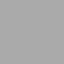

In [25]:
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,100,100])
viewer.add_section(None,value=0,colour='white')
viewer.add_section(None,axis='y',value=0,colour='white')

for f in faults[:2]:
    try:
#     print(f['feature'].name)
#     print(f['feature'])
        viewer.add_isosurface(f['feature'][0],
#                               slices=[-1,0,1],
#                             paint_with=f['feature'].displacementfeature,

                              isovalue=0
                             )
#         viewer.add_isosurface(f['feature'][1],
#                               slices=[-1,0,1],
#                             paint_with=f['feature'].displacementfeature

# #                               isovalue=0
#                              )
#         viewer.add_isosurface(f['feature'][2],
#                               slices=[-1,0,1],
#                               paint_with=f['feature'].displacementfeature
# #                               isovalue=0
#                              )
        viewer.add_data(f['feature'][0],cmap='rainbow')
#     viewer.add_scalar_field(f['feature'].displacementfeature,
#                           slices=[-0.01,0.01]#isovalue=0
#                          )
    except:
        continue
# viewer.add_isosurface(strati['feature'],
# #                       nslices=10,
#                   slices= strat_val.values(),
# #                     voxet={'bounding_box':boundary_points,'nsteps':(100,100,50)},
#                   paint_with=strati['feature'],
#                   cmap='tab20'

#                  )
# viewer.add_section(strati['feature'],'z',0)
# viewer.add_scalar_field(strati['feature'],
# #                       nslices=10,
#                   slices= strat_val.values(),
# #                     voxet={'bounding_box':boundary_points,'nsteps':(100,100,50)},
#                   paint_with=strati['feature'],
#                   cmap='tab20'

#                  )
#         viewer.add_isosurface(f['feature'][1],
#                               nslices=5
#                          )
#         viewer.add_isosurface(f['feature'][2],
#                               nslices=5
#                          )
#         # viewer.add_scalar_field(faults[0]['feature'])
#         viewer.add_data(f['feature'][0])
#         viewer.add_data(f['feature'][1])
#         viewer.add_data(f['feature'][2])

    
viewer.interactive()

### Add stratigrapy to the model and the faults will be added to this

In [31]:
strati = model.create_and_add_foliation('s0', #identifier in data frame
                                                    interpolatortype="PLI", #which interpolator to use
                                                    nelements=1e4, # how many tetras/voxels
                                                    buffer=0.2, # how much to extend nterpolation around box
                                                    solver='lu',
                                                    damp=True
                                                   )



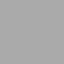

In [32]:
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,100,50])
viewer.add_section(None,value=0,colour='white')
viewer.add_section(None,axis='y',value=0,colour='white')
for f in faults:
    try:
#     print(f['feature'].name)
#     print(f['feature'])
        viewer.add_isosurface(f['feature'][0],
    #                           slices=[-1,0,1]
                              isovalue=0
                             )
#     viewer.add_scalar_field(f['feature'].displacementfeature,
#                           slices=[-0.01,0.01]#isovalue=0
#                          )
    except:
        continue
# viewer.add_isosurface(strati['feature'],
# #                       nslices=10,
#                   slices= strat_val.values(),
# #                     voxet={'bounding_box':boundary_points,'nsteps':(100,100,50)},
#                   paint_with=strati['feature'],
#                   cmap='tab20'

#                  )
viewer.add_section(strati['feature'],'z',.10,cmap='tab20')
# viewer.add_scalar_field(strati['feature'],
# #                       nslices=10,
#                   slices= strat_val.values(),
# #                     voxet={'bounding_box':boundary_points,'nsteps':(100,100,50)},
#                   paint_with=strati['feature'],
#                   cmap='tab20'

#                  )
#         viewer.add_isosurface(f['feature'][1],
#                               nslices=5
#                          )
#         viewer.add_isosurface(f['feature'][2],
#                               nslices=5
#                          )
#         # viewer.add_scalar_field(faults[0]['feature'])
#         viewer.add_data(f['feature'][0])
#         viewer.add_data(f['feature'][1])
#         viewer.add_data(f['feature'][2])

    
viewer.interactive()


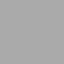

In [33]:
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,100,100])
viewer.add_section(None,value=0,colour='white')
viewer.add_section(None,axis='y',value=0,colour='white')
for f in faults:
    try:
#     print(f['feature'].name)
#     print(f['feature'])
        viewer.add_isosurface(f['feature'][0],
    #                           slices=[-1,0,1]
                              isovalue=0
                             )
#     viewer.add_scalar_field(f['feature'].displacementfeature,
#                           slices=[-0.01,0.01]#isovalue=0
#                          )
    except:
        continue
viewer.add_isosurface(strati['feature'],
#                       nslices=10,
                  slices= strat_val.values(),
#                     voxet={'bounding_box':boundary_points,'nsteps':(100,100,50)},
                  paint_with=strati['feature'],
                  cmap='tab20'

                 )

#         viewer.add_isosurface(f['feature'][1],
#                               nslices=5
#                          )
#         viewer.add_isosurface(f['feature'][2],
#                               nslices=5
#                          )
#         # viewer.add_scalar_field(faults[0]['feature'])
#         viewer.add_data(f['feature'][0])
#         viewer.add_data(f['feature'][1])
#         viewer.add_data(f['feature'][2])

    
viewer.interactive()

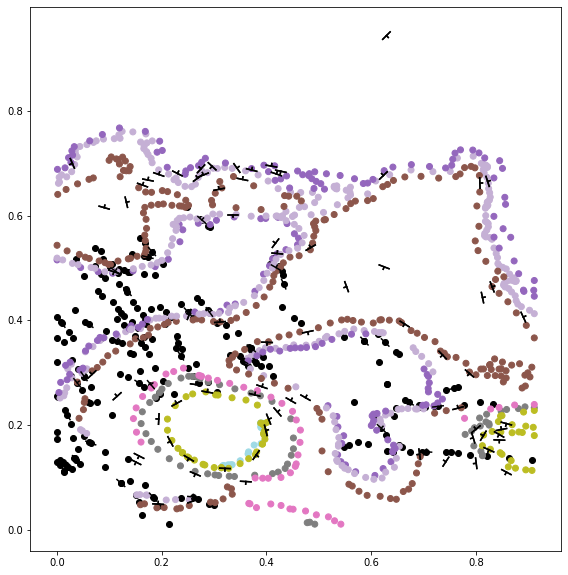

In [20]:
from LoopStructural.visualisation import MapView
map_view = MapView(model)
for f in faults:
#     print(f['feature'][0]))
    map_view.add_data(f['feature'][0],scale=0.02,point_colour='k',size=1)
map_view.add_data(strati['feature'],scale=0.01,cmap='tab20')